In [1]:
import os

import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

from moviepy.editor import VideoFileClip
from IPython.display import HTML


In [27]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        # Initialize all others not carried over between first detections
        self.reset()

    def reset(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # recent polynomial coefficients
        self.recent_fit = []
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # x values for detected line pixels
        self.all_x = None  
        # y values for detected line pixels
        self.all_y = None
        # counter to reset after 5 iterations if issues arise
        self.counter = 0 
        
    def counter(self):
        ''' 
        Resets the line class upon failing five times in a row.
        '''
        # Reset if failed at least five times
        if self.counter >= 5:
            self.reset()
    
    def fit_line(self,x_p,y_p,run_one=True):
        '''
        Fit a second order polynomial to the line.
        This function tries first and if it fails, it either resets the line
        or add it to the counter
        '''
        try:
            p = 5
            
            # Fit a line
            self.current_fit = np.polyfit(y_p,x_p,2)
            
            # Assign x and y to the class variable
            self.all_x = x_p
            self.all_y = y_p
            
            # Append the current fit to the recent points
            self.recent_fit.append(self.current_fit)
            
            if len(self.recent_fit) > 1:
                self.diffs = (self.recent_fit[-2] - self.recent_fit[-1]) / self.recent_fit[-2]
            self.recent_fit = self.recent_fit[-p:]
            self.best_fit = np.mean(self.recent_fit, axis = 0)
            line_fit = self.current_fit
            self.detected = True
            self.counter = 0
            
            return line_fit
        
        except(TypeError, np.linalg.LinAlgError):
            line_fit = self.best_fit
            
            # On the first attempt, reset all the variables
            if run_one == True:
                self.reset()
            else:
                self.counter()
            
            return line_fit
    
    def draw(self, mask, color=(255, 0, 0), line_width=50, average=False):
        """
        Draw the line on a color mask image.
        """
        ht, wd, c = mask.shape

        plot_y = np.linspace(0, ht - 1, ht)
        coeffs = self.best_fit if average else self.current_fit

        line_center = coeffs[0] * plot_y ** 2 + coeffs[1] * plot_y + coeffs[2]
        line_left_side = line_center - line_width // 2
        line_right_side = line_center + line_width // 2

        # Some magic here to recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array(list(zip(line_left_side, plot_y)))
        pts_right = np.array(np.flipud(list(zip(line_right_side, plot_y))))
        pts = np.vstack([pts_left, pts_right])

        # Draw the lane onto the warped blank image
        return cv2.fillPoly(mask, [np.int32(pts)], color)

def cam_calibrate():
    """
    This function extracts the camera matrix and distortion 
    coefficients from a set of camera images
    Inputs: Folder containing set of camera images
    Output: Distortion coefficient and camera matrix
    """

    # prepare object points
    # Number of inside corners for x
    nx = 9 
    # Number of inside corners for y
    ny = 6 

    # Read the test images folder
    chessBoardImages = os.listdir("camera_cal/")

    # Setup arrays to store object points and image points
    objpoints = [] # 3D points in real world space
    imgp = [] # 2D points in image plane

    # Create the object points now
    objp = np.zeros((6*9,3),np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Loop through all the images in the folder
    for i in chessBoardImages:
        i = "camera_cal/" + i
        img = cv2.imread(i)
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        corners_found, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, Draw and display the corners
        if corners_found is True:
            # Update the image points with the corners found
            imgp.append(corners)
            #Update the object points
            objpoints.append(objp)
            img = cv2.drawChessboardCorners(img, (nx, ny), corners, corners_found)

    corners_found, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgp, gray.shape[::-1], None, None)

    return corners_found,mtx,dist,rvecs,tvecs

def img_undistort(img, mtx, dist):
    """
    Undistort an image considering the distortion coefficients and
    camera matrix
    Inputs: Image you want undistorted
    Output: Undistorted image
    """
    return cv2.undistort(img, mtx, dist, None, mtx)

def thresholding(img,mtx,dist,kernel_size,color_thrsh=(110,255),gradient_thrsh=(15,95)):
    """
    This function returns the binary output after 
    applying a color thresholding and gradient thresholding
    using a sobel filter
    Inputs: RGB image
    Output: binary image
    """
    
    undist_img = img_undistort(img, mtx, dist)

    # Convert the image to hls
    hls = cv2.cvtColor(undist_img,cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Calculate the sobel magnitudes
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = kernel_size)
    abs_sobelx = np.absolute(sobel_x)
    scaled_sobelx = np.uint8(255*abs_sobelx / np.max(abs_sobelx))

    # Color thresholding
    color_binary = np.zeros_like(s_channel)
    color_binary[(s_channel > color_thrsh[0]) & (s_channel <= color_thrsh[1])] = 1

    # Gradient thresholding
    gradient_binary = np.zeros_like(scaled_sobelx)
    gradient_binary[(scaled_sobelx > gradient_thrsh[0]) & (scaled_sobelx <= gradient_thrsh[1])] = 1

    # Combined threshold
    comb_thrsh_binary = np.zeros_like(gradient_binary)
    # If any of the pixels in the color threshold image or the gradient image are
    # true apply it to the combined binary image
    comb_thrsh_binary[(color_binary == 1) | (gradient_binary ==1)] = 1
    
    # Fill the gaps in the binary image
    #kernel = np.ones((5, 5), np.uint8)
    #comb_thrsh_binary = cv2.morphologyEx(comb_thrsh_binary.astype(np.uint8), cv2.MORPH_CLOSE, kernel)

    return comb_thrsh_binary

def perspective_transform(img,mtx,dist):
    """
    This function defines how to transform an image
    into a top view or a bird eye view to help 
    find the lanes better
    Inputs:Undistorted binary image
    Output:Transformed image
    """
    binary_img = thresholding(img, mtx, dist,9)
    
    # Convert the image to grayscale and the get the dimensions of it
    #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img_size = (binary_img.shape[1],binary_img.shape[0])
    width = img_size[0]
    height = img_size[1]

    # Define the source points for the perspective transform
    src_pts = np.float32([[width,height-10],[0,height-10],[543,461],[731,461]])
    dst_pts = np.float32([[width, height],[0, height],[0, 0],[width, 0]])

    # Calculate the transform matrix
    M = cv2.getPerspectiveTransform(src_pts,dst_pts)

    # Apply the transformation matrix on the image to warp it
    transformed_image = cv2.warpPerspective(binary_img,M,img_size,flags=cv2.INTER_LINEAR)

    return transformed_image,M

def create_window(x_curr, margin, minpix, nonzerox, nonzeroy, 
                   win_y_low, win_y_high, max_window, counter, side):
    '''
    Creates a window, then checks for non-zero value pixels within it.
    If there are more than minpix, the window gets re-centered to their mean.
    Lastly, if at least five windows have been used, check whether we have
    hit the outside of the image.
    '''
    # Identify window boundaries
    win_x_low = x_curr - margin
    win_x_high = x_curr + margin
    # Identify the nonzero pixels in x and y within the window
    good_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) 
                 & (nonzerox >= win_x_low) & (nonzerox < win_x_high)).nonzero()[0]
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_inds) > minpix:
        x_curr = np.int(np.mean(nonzerox[good_inds]))
    if counter >= 5:
        if win_x_high > max_window or win_x_low < 0:
            if side == 'left':
                left_tracker = False
            else:
                right_tracker = False
    return good_inds, x_curr

def find_lane_pixels(img,mtx,dist):
    '''
    This will find the coefficients for the polynomial
    to be used later when we find the lane lines
    '''
    
    binary_warped,perspective_matrix = perspective_transform(img,mtx,dist)
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 30
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base    

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    left_tracker = True
    right_tracker = True
    counter = 0

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        max_window = binary_warped.shape[1]
        
        # Identify the nonzero pixels in x and y within the window #
        if left_tracker == True and right_tracker == True:
            good_left_inds,leftx_current = create_window(leftx_current, margin, minpix, nonzerox, nonzeroy, 
                                                           win_y_low, win_y_high, max_window, counter, 'left')
            good_right_inds, rightx_current = create_window(rightx_current, margin, minpix, nonzerox, nonzeroy, 
                                                             win_y_low, win_y_high, max_window, counter, 'right')
            
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            #Increment the counter
            counter+=1
            
        elif left_tracker == True:
            good_left_inds,leftx_current = create_window(leftx_current, margin, minpix, nonzerox, nonzeroy, 
                                                           win_y_low, win_y_high, max_window, counter, 'left')
            
            left_lane_inds.append(good_left_inds)
        
        elif right_tracker == True:
            good_right_inds, rightx_current = create_window(rightx_current, margin, minpix, nonzerox, nonzeroy, 
                                                             win_y_low, win_y_high, max_window, counter, 'right')
            
            right_lane_inds.append(good_right_inds)
            
        else:
            break

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each line
    left_fit = left_line.fit_line(leftx, lefty, True)
    right_fit = right_line.fit_line(rightx, righty, True)
    

def draw_lines(img,mtx,dist):
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 150
    
    # Call the function that returns a binary warped image
    binary_warped, perspective_matrix = perspective_transform(img, mtx, dist)
    
    # Check if lines were detected previously. If not find lanes first
    if left_line.detected == False or right_line.detected == False:
        find_lane_pixels(img,mtx,dist)
        
    # Set the lines to the current fit for now
    left_fit = left_line.current_fit
    right_fit = right_line.current_fit

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    # Fit a second order polynomial to each again.
    left_fit = left_line.fit_line(leftx, lefty, False)
    right_fit = right_line.fit_line(rightx, righty, False)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Calculate the pixel curve radius
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    # Convert from x and y pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_ws = np.polyfit(left_line.all_y*ym_per_pix,left_line.all_x*xm_per_pix,2)
    right_fit_ws = np.polyfit(right_line.all_y*ym_per_pix,right_line.all_x*xm_per_pix,2)
    
    # Calculate the radius of curvature in world space
    left_curverad_numer = (1+((2*left_fit_ws[0]*y_eval*ym_per_pix)+left_fit_ws[1])**2)**1.5
    left_curverad_denom = np.absolute(2*left_fit_ws[0])
    
    right_curverad_numer = (1+((2*right_fit_ws[0]*y_eval*ym_per_pix)+right_fit_ws[1])**2)**1.5
    right_curverad_denom = np.absolute(2*right_fit_ws[0])
    
    ## Implement the calculation of the left line here
    left_curverad = left_curverad_numer/left_curverad_denom
    ## Implement the calculation of the right line here
    right_curverad = right_curverad_numer/right_curverad_denom
    
    # Find the average radius of curvature for both left and the right lines
    avg_rad_cur = round(np.mean([left_curverad, right_curverad]),0)
    rad_cur_text = 'Radius of Curvature = {}(m)'.format(avg_rad_cur)
    
    # Calculating middle of the image, aka where the car camera is
    mid_image = img.shape[1] / 2
    car_pos = mid_image * xm_per_pix

    # Calculating middle of the lane
    left_line_base = (left_fit_ws[0] * img.shape[0] * ym_per_pix ** 2) + (left_fit_ws[1] * img.shape[0] * ym_per_pix) + left_fit_ws[2]

    right_line_base = (right_fit_ws[0] * img.shape[0] * ym_per_pix ** 2) + (right_fit_ws[1] * img.shape[0] * ym_per_pix) + right_fit_ws[2]
    
    lane_mid = (left_line_base+right_line_base)/2

    # Calculate distance from center and list differently based on left or right
    dist_from_center = lane_mid - car_pos
    if dist_from_center >= 0:
        center_text = '{} meters left of center'.format(round(dist_from_center,2))
    else:
        center_text = '{} meters right of center'.format(round(-dist_from_center,2))
        
    # List car's position in relation to middle on the image and radius of curvature
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img, center_text, (10,50), font, 1,(255,0,0),2)
    cv2.putText(img, rad_cur_text, (10,100), font, 1,(0,0,255),2)

    # Invert the transform matrix from birds_eye (to later make the image back 
    #   to normal below)
    Minv = np.linalg.inv(perspective_matrix)

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective 
    #   matrix (Minv)
    road_dewarped = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0]))
    
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, road_dewarped, 0.3, 0)
    
    # Draw solid lines onto the lane lines assuming you are using the current pts
    line_warp = np.zeros_like(img)
    line_warp = left_line.draw(line_warp, color=(255, 0, 0), average=False)
    line_warp = right_line.draw(line_warp, color=(0, 0, 255), average=False)
    line_dewarped = cv2.warpPerspective(line_warp, Minv, (img.shape[1], img.shape[0]))
    
    lines_mask = result.copy()
    idx = np.any([line_dewarped != 0][0], axis=2)
    lines_mask[idx] = line_dewarped[idx]
    
    result = cv2.addWeighted(src1=lines_mask, alpha=0.8, src2=result, beta=0.5, gamma=0.)
    
    return result

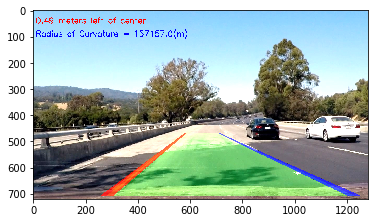

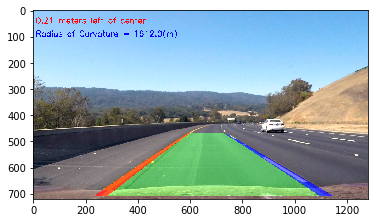

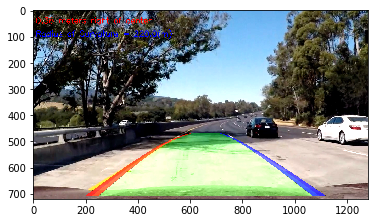

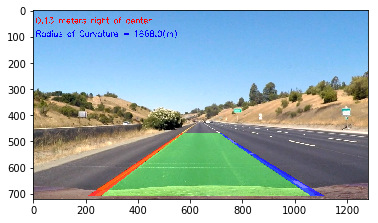

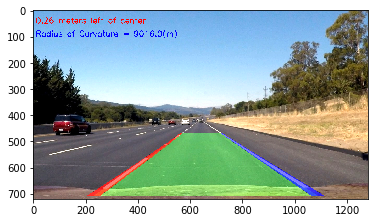

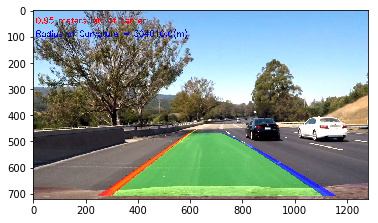

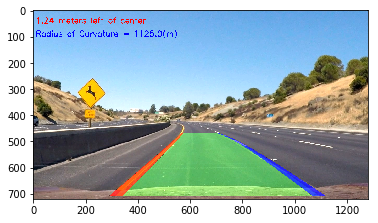

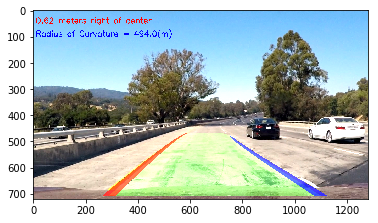

In [3]:
if __name__ == '__main__':
    # Set the class lines equal to the variables used above
    left_line = Line()
    right_line = Line()
    
    test_imgs = os.listdir("test_images/")
    # Function call to camera calibrate function to obtain 
    # the distortion coefficients and the camera matrix
    corners_found,mtx,dist,rvecs,tvecs = cam_calibrate()
    
    # Convert to video
    # vid_output is where the image will be saved to
    vid_output = 'output_images/output_project_video.mp4'

    # The file referenced in clip1 is the original video before anything has 
    #   been done to it
    frame_fromVideo = VideoFileClip('project_video.mp4')

    # NOTE: this function expects color images
    vid_clip = frame_fromVideo.fl_image(lambda image: draw_lines(image, mtx, dist))
    vid_clip.write_videofile(vid_output, audio=False)
    
    for imgname in test_imgs:
        imgname = "test_images/" + imgname
        
        # Read the image
        test_img = mpimg.imread(imgname)
        
        result = draw_lines(test_img,mtx,dist)

        plt.imshow(result)
        plt.show()

    #mpimg.imsave("output_images/LineFittedImage.jpg",out_img,cmap='gray')

In [227]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_output))

In [229]:
# vid_output is where the image will be saved to
vid_challenge_output = 'output_images/output_challenge_video.mp4'

# The file referenced in clip1 is the original video before anything has 
#   been done to it
frame_fromVideo = VideoFileClip('challenge_video.mp4')

# NOTE: this function expects color images
vid_clip = frame_fromVideo.fl_image(lambda image: draw_lines(image, mtx, dist))
vid_clip.write_videofile(vid_challenge_output, audio=False)

[MoviePy] >>>> Building video output_images/output_challenge_video.mp4
[MoviePy] Writing video output_images/output_challenge_video.mp4


100%|██████████| 485/485 [02:11<00:00,  3.73it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/output_challenge_video.mp4 



In [230]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(vid_challenge_output))

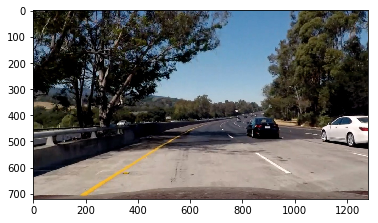

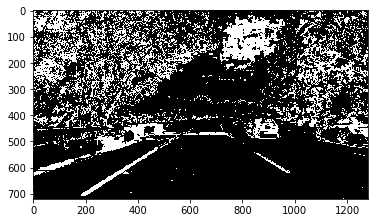

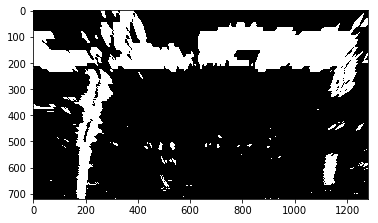

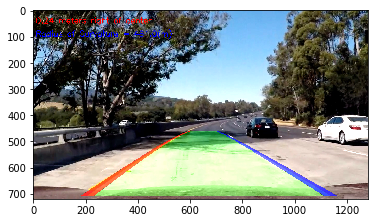

In [28]:
ex_img = mpimg.imread("test_images/test5.jpg")

corners_found,mtx,dist,rvecs,tvecs = cam_calibrate()

undist_img = img_undistort(ex_img,mtx,dist)
plt.imshow(undist_img)
plt.show()

binary_img = thresholding(ex_img,mtx,dist,3,color_thrsh=(110,255),gradient_thrsh=(30,100))
plt.imshow(binary_img,cmap='gray')
plt.show()

binary_warped_img,M = perspective_transform(ex_img,mtx,dist)
plt.imshow(binary_warped_img,cmap='gray')
plt.show()

left_line = Line()
right_line = Line()
result = draw_lines(ex_img,mtx,dist)
plt.imshow(result)
plt.show()

mpimg.imsave("output_images/undistorted_test_image.jpg",undist_img)
mpimg.imsave("output_images/color_gradient_binary.jpg",binary_img,cmap='gray')
mpimg.imsave("output_images/binary_warped.jpg",binary_warped_img,cmap='gray')
mpimg.imsave("output_images/line_fitted_image.jpg",result)